Import

In [109]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import torch.nn.functional as F
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure

Resource check

In [110]:
# ON MACOS
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print('Device available:', device)

# ON WINDOWS
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Device available:', device)

Device available: mps


Dataload

In [111]:
# Loading TIFF images for Super-resolution
class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, transform=None):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.transform = transform
        self.filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])
    
    # Get the number of samples in the dataset
    def __len__(self):
        return len(self.filenames)

    # Get the sample at the given index
    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_dir, self.filenames[idx])
        low_res_path = os.path.join(self.low_res_dir, self.filenames[idx])

        # Load images
        high_res = Image.open(high_res_path)
        low_res = Image.open(low_res_path)

        # Resize low-res to 128x128 (ensuring correct input size)
        low_res = low_res.resize((128, 128), Image.BICUBIC)

        # Apply transformations
        if self.transform:
            high_res = self.transform(high_res)
            low_res = self.transform(low_res)

        return low_res, high_res  # Returning input-output pairs

# Define a transform to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

flip = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor()
])

# Define a transform to convert images to PyTorch tensors with normalization
normalize = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# normalize_flip = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5]),
#     transforms.RandomHorizontalFlip(p=1.0)
# ])

# Create the dataset for training images
train_dataset = TIFFDataset('data/train/high-res', 'data/train/low-res', transform=transform)
# Create the dataset for training images with flipping
# train_dataset_flip = TIFFDataset('data/train/high-res', 'data/train/low-res', transform=flip)

# Combine the datasets
# train_dataset = torch.utils.data.ConcatDataset([train_dataset, train_dataset_flip])

# Function to create data loader
def create_loader(dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print dataset size
dataset_size = len(train_dataset)
print('Number of images in the dataset:', dataset_size)

Number of images in the dataset: 240


Define Network

In [112]:
class testNet(nn.Module):
    def __init__(self):
        super(testNet, self).__init__()
        self.gelu = nn.GELU()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.gelu(self.conv1(x))
        x = self.gelu(self.conv2(x))
        x = self.conv3(x)

        return x

Training Fn

In [113]:
def train_model(model, opt, criterion, train_loader, num_epoch):
    avg_train_losses = []

    for epoch in range(num_epoch):  # Loop over the dataset multiple times
        model.train()
        total_train_loss = 0

        for i, (x_tr_batch, y_tr_batch) in enumerate(train_loader):  # Loop over mini-batches
            x_tr_batch, y_tr_batch = x_tr_batch.to(device), y_tr_batch.to(device)

            # Upsample low-resolution input to 256x256
            # x_tr_batch = torch.nn.functional.interpolate(x_tr_batch, scale_factor=2, mode='bicubic', align_corners=False)

            opt.zero_grad()  # Delete previous gradients
            y_hat_tr_batch = model(x_tr_batch)  # Forward pass
            loss = criterion(y_hat_tr_batch, y_tr_batch)  # Compute loss
            loss.backward()  # Backward pass
            opt.step()  # Update weights
            total_train_loss += loss.item()  # Accumulate loss

            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item():.6f}')

        avg_train_loss = total_train_loss / len(train_loader)  # Compute average loss
        avg_train_losses.append(avg_train_loss)  # Store average loss

    # Plot training loss
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(1, num_epoch + 1), avg_train_losses, label='training loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')  # Log scale for better visualization
    ax.set_title('training loss')
    ax.grid(True)
    ax.legend()
    plt.show()

Train

Epoch 1, Iteration 10, Loss: 0.009769


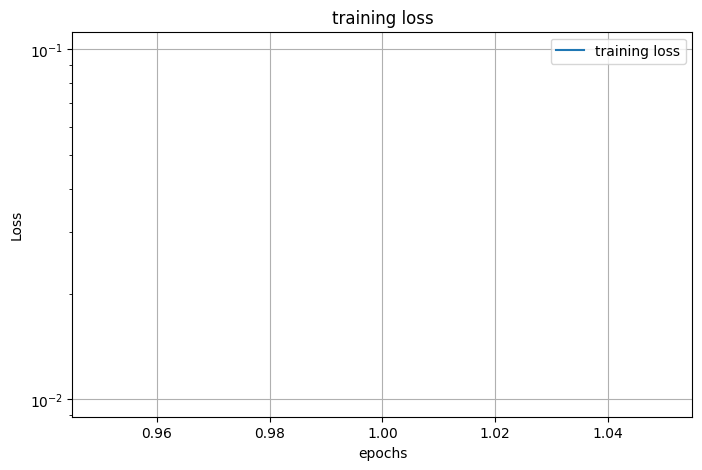

In [114]:
batch_size = 15  # Number of complete images in each batch
lr = 1e-3  # Learning rate
num_epoch = 1  # Epochs

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
model = testNet().to(device)  # Pick a model and move to GPU/CPU
opt = optim.Adam(model.parameters(), lr=lr)  # Pick an optimizer
criterion = nn.MSELoss()  # Pick a loss function

# Train the model
train_model(model, opt, criterion, train_loader, num_epoch)

MAC Stupidity

In [ ]:
device = torch.device('cpu')
model.to(device, verbose=False)

testNet(
  (gelu): GELU(approximate='none')
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Metrics

In [116]:
# Dataset for validation
val_dataset = TIFFDataset('data/val/high-res', 'data/val/low-res', transform=transform)

# Initialize metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Accumulators
total_psnr_interpolated = 0
total_psnr_super_resolved = 0
total_ssim_interpolated = 0
total_ssim_super_resolved = 0
num_samples = len(val_dataset)

# Loop over validation set
for i in range(num_samples):
    val_low_res, val_high_res = val_dataset[i]
    val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

    # Compute data range dynamically
    data_range = val_high_res.max() - val_high_res.min()
    ssim_metric.data_range = data_range

    # Upsample low-res image

    val_low_res_up = nn.functional.interpolate(val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False)

    val_high_res = val_high_res  # Add batch dim

    # val_super_res = model(val_low_res_up).detach()

    val_super_res = model(val_low_res.unsqueeze(0)).detach()

    # PSNR
    # psnr_interp = psnr_metric(val_low_res_up, val_high_res).item()
    psnr_interp = psnr_metric(val_low_res_up, val_high_res).item()
    psnr_sr = psnr_metric(val_super_res, val_high_res).item()

    # SSIM (data_range is now set in metric initialization)
    # ssim_interp = ssim_metric(val_low_res_up, val_high_res).item()
    ssim_interp = ssim_metric(val_low_res_up, val_high_res.unsqueeze(0)).item()
    ssim_sr = ssim_metric(val_super_res, val_high_res.unsqueeze(0)).item()

    # Accumulate
    total_psnr_interpolated += psnr_interp
    total_psnr_super_resolved += psnr_sr
    total_ssim_interpolated += ssim_interp
    total_ssim_super_resolved += ssim_sr

# Averages
avg_psnr_interp = total_psnr_interpolated / num_samples
avg_psnr_sr = total_psnr_super_resolved / num_samples
avg_ssim_interp = total_ssim_interpolated / num_samples
avg_ssim_sr = total_ssim_super_resolved / num_samples

# Print results
print(f'Average PSNR (interpolated): {avg_psnr_interp:.2f} dB')
print(f'Average PSNR (super-resolved): {avg_psnr_sr:.2f} dB')
print(f'Average SSIM (interpolated): {avg_ssim_interp:.4f}')
print(f'Average SSIM (super-resolved): {avg_ssim_sr:.4f}')

Average PSNR (interpolated): 30.81 dB
Average PSNR (super-resolved): 21.98 dB
Average SSIM (interpolated): 0.9056
Average SSIM (super-resolved): 0.7083
